# Eye Colour and Baldness detection
`In this module I will use deep learning networks to classify a face image to find whether the person is bald or not.`

## Getting the data ready
### Download data from kaggle

In [ ]:
!pip install kaggle --upgrade
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d ashishjangra27/bald-classification-200k-images-celeba
!unzip bald-classification-200k-images-celeba.zip
!rm bald-classification-200k-images-celeba.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/NotBald/197480.jpg  
  inflating: Dataset/Validation/NotBald/197482.jpg  
  inflating: Dataset/Validation/NotBald/197483.jpg  
  inflating: Dataset/Validation/NotBald/197484.jpg  
  inflating: Dataset/Validation/NotBald/197485.jpg  
  inflating: Dataset/Validation/NotBald/197486.jpg  
  inflating: Dataset/Validation/NotBald/197487.jpg  
  inflating: Dataset/Validation/NotBald/197488.jpg  
  inflating: Dataset/Validation/NotBald/197489.jpg  
  inflating: Dataset/Validation/NotBald/197490.jpg  
  inflating: Dataset/Validation/NotBald/197491.jpg  
  inflating: Dataset/Validation/NotBald/197492.jpg  
  inflating: Dataset/Validation/NotBald/197493.jpg  
  inflating: Dataset/Validation/NotBald/197494.jpg  
  inflating: Dataset/Validation/NotBald/197495.jpg  
  inflating: Dataset/Validation/NotBald/197496.jpg  
  inflating: Dataset/Validation/NotBald/197497.jpg  
  inflating: Dataset/Validation/NotBald/197498.j

In [ ]:
!pip install MTCNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 25.0 MB/s 


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-31 16:09:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-31 16:09:19 (99.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Importing Dependencies

In [ ]:
from helper_functions import *
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os, random
import matplotlib.image as mpimg
import glob
import cv2
from mtcnn.mtcnn import MTCNN

### Know our datasets

In [ ]:
path = 'Dataset/Train/Bald'
bald = []
notbald = []
for i in os.listdir(path):
        bald.append(os.path.join(path,i))
path = 'Dataset/Train/NotBald'
for i in os.listdir(path):
        notbald.append(os.path.join(path,i))

In [ ]:
len(bald), len(notbald)

(3656, 156344)

In [ ]:
cat_img_count = int(len(bald) * 0.8)
dog_img_count = int(len(notbald) * 0.8)
for jpgfile in bald:
  os.remove(jpgfile)
  cat_img_count = cat_img_count - 1
  if cat_img_count == 0:
    break

for jpgfile in notbald:
  os.remove(jpgfile)
  dog_img_count = dog_img_count - 1
  if dog_img_count == 0:
    break

In [ ]:
walk_through_dir('Dataset')

There are 3 directories and 0 images in 'Dataset'.
There are 2 directories and 0 images in 'Dataset/Train'.
There are 0 directories and 732 images in 'Dataset/Train/Bald'.
There are 0 directories and 31269 images in 'Dataset/Train/NotBald'.
There are 2 directories and 0 images in 'Dataset/Validation'.
There are 0 directories and 470 images in 'Dataset/Validation/Bald'.
There are 0 directories and 22129 images in 'Dataset/Validation/NotBald'.
There are 2 directories and 0 images in 'Dataset/Test'.
There are 0 directories and 421 images in 'Dataset/Test/Bald'.
There are 0 directories and 19579 images in 'Dataset/Test/NotBald'.


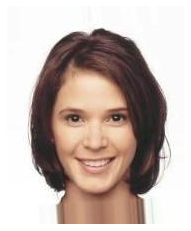

In [ ]:
filename = "Dataset/Train/NotBald/" +  random.choice(os.listdir("Dataset/Train/NotBald"))
img = mpimg.imread(filename)
plt.imshow(img)
plt.axis(False);

In [ ]:
import tensorflow as tf
train_dir = "Dataset/Train"
test_dir = "Dataset/Validation"

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224,224),
                                                                 label_mode="binary")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224,224),
                                                                label_mode="binary")

Found 32001 files belonging to 2 classes.
Found 22599 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.models.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
], name="data_augmentation")

## Preparing our model
### Create the model architecture

In [ ]:
# Create the model
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable=True
inputs = tf.keras.Input(shape=(224,224,3), name="inputs")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

### Compile the architectural model

In [ ]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

### Saving some Checkpoints

In [ ]:
checkpoint_path = "base_model/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

### Fit the model to our training dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
history_1 = model_1.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[checkpoint_callback,
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  patience=3),
                                 tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                                      factor=0.2, 
                                                                      patience=2,
                                                                      verbose=1,
                                                                      min_lr=1e-7),
                                 create_tensorboard_callback(dir_name="VGG_on_binary_1",
                                                             experiment_name="all_in_one_go")])

Saving TensorBoard log files to: VGG_on_binary_1/all_in_one_go/20220831-071533
Epoch 1/5
1001/1001 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9837
Epoch 1: val_loss improved from inf to 0.02527, saving model to base_model/checkpoint.ckpt
1001/1001 [==============================] - 973s 955ms/step - loss: 0.0450 - accuracy: 0.9837 - val_loss: 0.0253 - val_accuracy: 0.9906 - lr: 1.0000e-04
Epoch 2/5
1001/1001 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9884
Epoch 2: val_loss improved from 0.02527 to 0.02248, saving model to base_model/checkpoint.ckpt
1001/1001 [==============================] - 649s 647ms/step - loss: 0.0299 - accuracy: 0.9884 - val_loss: 0.0225 - val_accuracy: 0.9912 - lr: 1.0000e-04
Epoch 3/5
1001/1001 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9885
Epoch 3: val_loss did not improve from 0.02248
1001/1001 [==============================] - 547s 546ms/step - loss: 0.0301 - accuracy: 0

## Evaluating the model

In [ ]:
result_1 = model_1.evaluate(test_data)
result_1

707/707 [==============================] - 74s 104ms/step - loss: 0.0275 - accuracy: 0.9891


[0.02749689109623432, 0.9891145825386047]

### To make sure our model trained well and didn't overfit

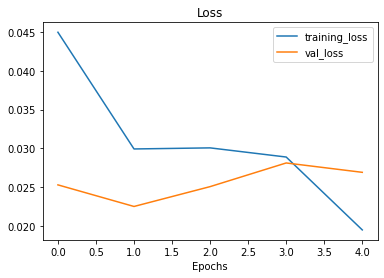

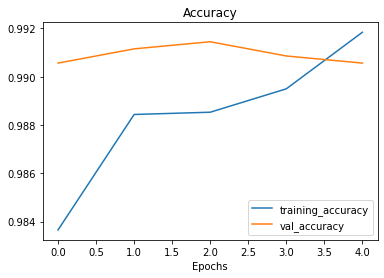

In [ ]:
plot_loss_curves(history_1)

## Testing our model in real life scenarios

1.   Bald image
2.   Non-Bald image


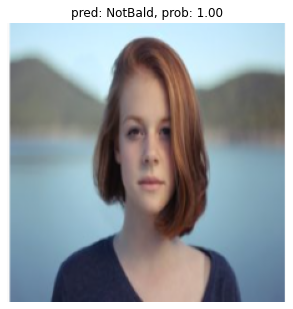

In [ ]:
def show_pred_image(filename):
  plt.figure(figsize=(5,7))
  image = load_and_prep_image(filename, scale=False)
  image = image[:,:,:3]
  pred_prob = model_1.predict(tf.expand_dims(image, axis=0))
  if  pred_prob >= 0.5:
    pred_class = "NotBald" 
  else:
    pred_class = "Bald"
    pred_prob = 1.0 - pred_prob
  plt.imshow(image/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob[0][0]:.2f}")
  plt.axis(False)
show_pred_image("/content/Real_Life_Images/Screenshot from 2022-08-31 14-11-19.png")

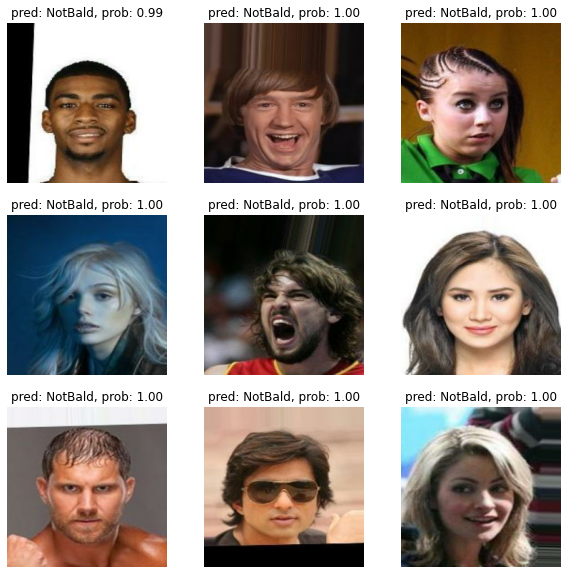

In [ ]:
# See some of the predictions in action

filename = ["Dataset/Validation/NotBald/" + filenames for filenames in os.listdir("Dataset/Validation/NotBald")]
rnd = np.random.randint(len(filename)-9)
plt.figure(figsize=(10,10))
i=0
for img in filename[rnd:rnd+9]:
  image = load_and_prep_image(img, scale=False)
  pred_prob = model_1.predict(tf.expand_dims(image, axis=0))
  if  pred_prob >= 0.5:
    pred_class = "NotBald" 
  else:
    pred_class = "Bald"
    pred_prob = 1.0 - pred_prob
  i = i+1
  plt.subplot(3,3,i)
  plt.imshow(image/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob[0][0]:.2f}")
  plt.axis(False)

## Save our model

In [ ]:
!mkdir /content/drive/MyDrive/baldness_recognition

In [ ]:
model_1.save("/content/drive/MyDrive/baldness_recognition/baldness_prediction_model")

In [ ]:
detector = MTCNN()
class_name = ("Blue", "Blue Gray", "Brown", "Brown Gray", "Brown Black", "Green", "Green Gray", "Other")
EyeColor = {
    class_name[0] : ((166, 21, 50), (240, 100, 85)),
    class_name[1] : ((166, 2, 25), (300, 20, 75)),
    class_name[2] : ((2, 20, 20), (40, 100, 60)),
    class_name[3] : ((20, 3, 30), (65, 60, 60)),
    class_name[4] : ((0, 10, 5), (40, 40, 25)),
    class_name[5] : ((60, 21, 50), (165, 100, 85)),
    class_name[6] : ((60, 2, 25), (165, 20, 65))
}

def check_color(hsv, color):
    if (hsv[0] >= color[0][0]) and (hsv[0] <= color[1][0]) and (hsv[1] >= color[0][1]) and hsv[1] <= color[1][1] and (hsv[2] >= color[0][2]) and (hsv[2] <= color[1][2]):
        return True
    else:
        return False
        
def find_class(hsv):
    color_id = 7
    for i in range(len(class_name)-1):
        if check_color(hsv, EyeColor[class_name[i]]) == True:
            color_id = i

    return color_id

def eye_color(image):
    imgHSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, w = image.shape[0:2]
    imgMask = np.zeros((image.shape[0], image.shape[1], 1))
    
    result = detector.detect_faces(image)
    if result == []:
        print('Warning: Can not detect any face in the input image!')
        return
        
    left_eye = result[0]['keypoints']['left_eye']
    right_eye = result[0]['keypoints']['right_eye']

    eye_distance = np.linalg.norm(np.array(left_eye)-np.array(right_eye))
    eye_radius = eye_distance/15 # approximate
   
    cv2.circle(imgMask, left_eye, int(eye_radius), (255,255,255), -1)
    cv2.circle(imgMask, right_eye, int(eye_radius), (255,255,255), -1)

    eye_class = np.zeros(len(class_name), np.float32)

    for y in range(0, h):
        for x in range(0, w):
            if imgMask[y, x] != 0:
                eye_class[find_class(imgHSV[y,x])] +=1 

    main_color_index = np.argmax(eye_class[:len(eye_class)-1])
    total_vote = eye_class.sum()

    print("\n\nDominant Eye Color: ", class_name[main_color_index])
    print("\n **Eyes Color Percentage **")
    for i in range(len(class_name)):
        print(class_name[i], ": ", round(eye_class[i]/total_vote*100, 2), "%")
    confe = round(eye_class[main_color_index]/total_vote*100, 2)
    label = 'Dominant Eye Color: %s' % class_name[main_color_index]  
    return label, confe

fname = "/content/Dataset/Test/Bald/160330.jpg"
image = cv2.imread(fname, cv2.IMREAD_COLOR)
# detect color percentage
label, confe = eye_color(image)
if(confe < 50):
  print(f"{label} = {confe}%")
else:
  print(label)



Dominant Eye Color:  Brown

 **Eyes Color Percentage **
Blue :  0.0 %
Blue Gray :  0.0 %
Brown :  7.69 %
Brown Gray :  0.0 %
Brown Black :  0.0 %
Green :  0.0 %
Green Gray :  0.0 %
Other :  92.31 %
Dominant Eye Color: Brown = 7.69%


# _________________THE END ___________________